In [3]:
##----- Installing Catboost library -----##
!pip install catboost

     |████████████████████████████████| 64.8MB 71kB/s 


In [4]:
##----- Loading Required Packages -----##
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import precision_score, make_scorer, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
##----- Reading Data -----##



bass = pd.read_csv("https://raw.githubusercontent.com/datascienceforsocialgood/HarmReduction/master/20-06-09%20BassCoast_CatBoost.csv")

In [7]:
##----- Cleaning Data so that it doesn't have any missing values ----##
bass["PreviousDC"].fillna(1, inplace=True)
bass["Obtained"].fillna("Offsite", inplace=True)
bass["Surprised1"].fillna(1, inplace=True)
bass["match2"].fillna("Match", inplace=True)
bass["combo_name"].fillna("Unknown", inplace=True)

bass['PreviousDC'] = bass['PreviousDC'].astype(object)
bass['Surprised1'] = bass['Surprised1'].astype(object)
bass['cluster'] = bass['cluster'].astype(float)

In [8]:
##----- Making numeric data categorical -----##
bass['PreviousDC'] = bass['PreviousDC'].map({0: "yes", 1: "no"})
bass['Surprised1'] = bass['Surprised1'].map({0: "yes", 1: "no"})

In [9]:
bass.head()

,UniqueKey,DateSurvey,UniqueCode,Consent,PreviousDC,PreviousBassCoastDC,Female,Male,Nonbinary,Trans,Gender_Unknown,Belief_MDMA_a,Belief_MDA_a,Belief_Ketamine_a,Belief_Cocaine_a,Belief_Methamphetamine_a,Belief_LSD_a,Belief_Unknown_a,Belief_Other_a,Belief_Other_detail_a,Type_Powder_s1,Type_Crystal_s1,Type_Blotter_s1,Type_PressTab_s1,Type_Liquid_s1,Type_Gummy_s1,Type_Other_s1,Type_Other_detail_s1,Type_Colour_s1,Testing_Self,Testing_Friends,Testing_Friends_num,Testing_Clients,Testing_Other,Testing_Other_detail,Obtained,Benzos_results,Benzo_Comments,LSD_result,Colorimetric_Comments,...,Intention_Other_a,Intention_Other_detail_a,Discarded,Initials,Final_comments,FTIR_result_MDMA_a1,FTIR_result_MDA_a1,FTIR_result_Ketamine_a1,FTIR_result_Cocaine_a1,FTIR_result_Methamphetamine_a1,FTIR_result_LSD_a1,FTIR_result_Unknown_a1,FTIR_result_Other_a1,match,Gender,count_substance,combinations,Intention_count,Intention_group,Behaviour_change,Type_count,Type,FTIR_result_MDMA_2,FTIR_result_MDA_2,FTIR_result_Ketamine_2,FTIR_result_Methamphetamine_2,FTIR_result_LSD_2,FTIR_result_Unknown_2,FTIR_result_Other_2,FTIR_result_Cocaine_2,match2,combo_name,cluster,match3,cluster1,mcluster,Intention,count_blf_substance,combinations_belief,combo_name_belief
0,509,2019-07-13,3769,0.0,no,NaN,1,0,1,1,1,1,1,1,0,1,1,1,1,NaN,0,1,1,1,1,1,1,NaN,white,0,0,10.0,1,1,NaN,Offsite,3.0,-,3.0,-,...,1,NaN,1.0,DL,-,1,1,1,0,1,1,1,1,Match,Male,1,"1, 1, 1, 0, 1, 1, 1, 1",1,No Change,No Change,1,Powder,1,1,1,1,1,1,1,0,Match,Cocaine,3.0,Match,3,9,No Change,1,"1, 1, 1, 0, 1, 1, 1, 1",Cocaine
1,71,2019-07-13,3770,0.0,no,NaN,0,1,1,1,1,1,1,0,1,1,1,1,1,NaN,1,0,1,1,1,1,1,NaN,white,0,1,NaN,1,1,NaN,Offsite,3.0,-,3.0,-,...,1,NaN,1.0,-,-,1,1,1,1,1,1,1,1,No Match,Female,0,"1, 1, 1, 1, 1, 1, 1, 1",2,Harm Reduction,No Change,1,Crystal,1,1,1,1,1,1,1,1,No Match,Unknown,7.0,No Match,8,2,Friend,1,"1, 1, 0, 1, 1, 1, 1, 1",Ketamine
2,199,2019-07-13,3771,0.0,yes,0.0,1,0,1,1,1,1,1,1,1,1,0,1,1,NaN,1,1,0,1,1,1,1,NaN,rainbow,0,1,NaN,1,1,NaN,Offsite,3.0,-,0.0,-,...,1,NaN,1.0,CJ,-,1,1,1,1,1,0,1,1,Match,Male,0,"1, 1, 1, 1, 1, 1, 1, 1",1,No Change,No Change,1,Blotter,1,1,1,1,1,1,1,1,Match,LSD,3.0,No Match,3,3,No Change,1,"1, 1, 1, 1, 1, 0, 1, 1",LSD
3,70,2019-07-13,3772,0.0,no,NaN,0,1,1,1,1,0,1,1,1,1,1,1,1,NaN,0,1,1,1,1,1,1,NaN,white,0,1,NaN,1,1,NaN,Onsite,3.0,-,3.0,-,...,1,NaN,1.0,-,-,0,1,1,1,1,1,1,1,Match,Female,1,"0, 1, 1, 1, 1, 1, 1, 1",1,No Change,No Change,1,Powder,0,1,1,1,1,1,1,1,Match,MDMA,8.0,Match,4,4,No Change,2,"0, 0, 1, 1, 1, 1, 1, 1","MDMA, MDA"
4,69,NaN,3773,0.0,no,NaN,0,1,1,1,1,0,1,1,1,1,1,1,1,NaN,1,1,1,1,1,1,1,NaN,brown,0,1,NaN,1,1,NaN,Onsite,3.0,-,3.0,-,...,1,NaN,1.0,-,ek: date and type of substance was not recorded,0,1,1,1,1,1,1,1,Match,Female,1,"0, 1, 1, 1, 1, 1, 1, 1",1,No Change,No Change,0,Other,0,1,1,1,1,1,1,1,Match,MDMA,8.0,Match,4,2,No Change,2,"0, 0, 1, 1, 1, 1, 1, 1","MDMA, MDA"


In [10]:
##----- Splitting Data into Train and Test -----##
X = bass.loc[:,["PreviousDC", "Surprised1","Gender", "Obtained", "Type", "match2",
               "combo_name"]]

Y = bass.loc[:, "Intention"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
cat_features = np.where(X_train.dtypes != float)[0]

**Model Training**

Now let's create the model itself: We would go here with default parameters (as they provide a really good baseline almost all the time), the only thing We would like to specify here is custom_loss parameter, as this would give us an ability to see what's going on in terms of this competition metric - accuracy, as well as to be able to watch for logloss, as it would be more smooth on dataset of such size.

In [11]:
model = CatBoostClassifier(iterations = 1000, 
    learning_rate = 0.1,
    random_strength = 0.1,
    custom_loss = ['Accuracy'],
    random_seed = 42,
    depth = 8,
    leaf_estimation_method='Newton',
    logging_level = 'Silent'
)

In [12]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test), #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

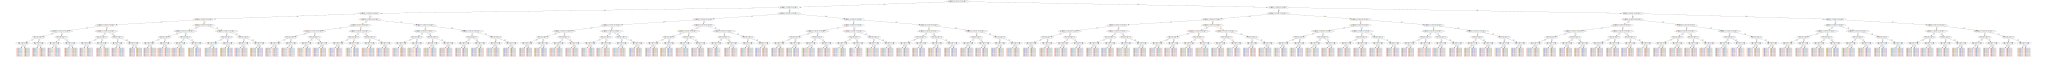

In [13]:
model.plot_tree(
    tree_idx=0,
     pool= X_train, 
)

**Model Cross-Validation**

In [14]:
##----- Cross Validating the model to get the long term Error Rate -----##
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'MultiClass'
})
cv_data = cv(
    Pool(X, Y, cat_features=cat_features),
    cv_params,
    plot=True
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
validate_pool = Pool(X_test, y_test, cat_features=cat_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.58±0.01 on step 7


In [16]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.5756645860213179


**Model Predictions**

In [17]:
predictions = model.predict(X_test)
print(predictions[50:60])
print(y_test[50:60])
## Model seems to only be predicting No Change. 

[['No Change']
 ['No Change']
 ['No Change']
 ['No Change']
 ['No Change']
 ['No Change']
 ['No Change']
 ['No Change']
 ['No Change']
 ['No Change']]
352    No Change
328       Friend
615    No Change
442    No Change
97        Friend
294    No Change
49     No Change
679    No Change
430    No Change
601    No Change
Name: Intention, dtype: object


**Variable Importance**

In [18]:
##----- Getting Variables that are important in determining the Interntion -----##
def rf_feature_importance(m, df):
    return(pd.DataFrame({"Feature": df.columns, "Importance": m.feature_importances_}
                        ).sort_values("Importance",ascending = False))

fi = rf_feature_importance(model, X_train)
fi

,Feature,Importance
2,Gender,24.096463
3,Obtained,23.556772
4,Type,23.250742
5,match2,11.396559
1,Surprised1,8.277156
0,PreviousDC,7.294464
6,combo_name,2.127843
